# Filter and Convolution Assignment

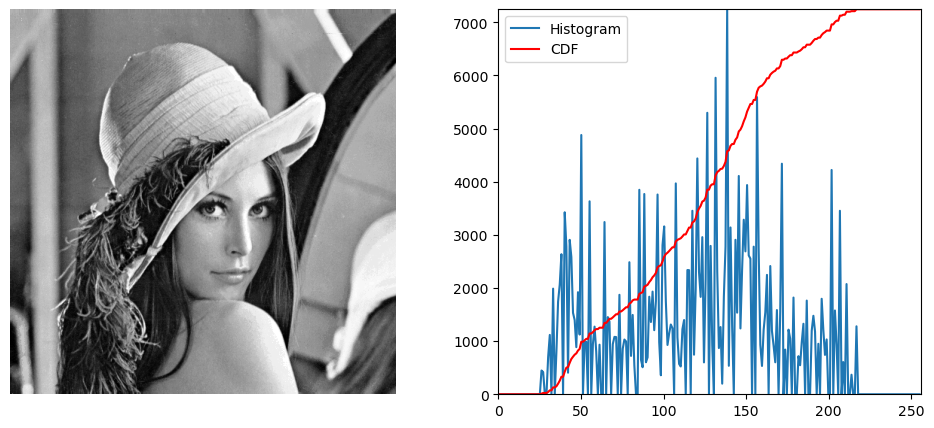

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def load_image(path):
    return cv2.imread(path, cv2.IMREAD_GRAYSCALE)

def plot_image_and_histogram(image, hist_range=(0, 256), cdf_range=(0, 1)):
    bins = np.linspace(hist_range[0], hist_range[1], 256)  # Adjust bins to match range
    hist, _ = np.histogram(image.flatten(), bins=bins)
    cdf = hist.cumsum()
    cdf_normalized = cdf / cdf.max()

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    axs[0].imshow(image, cmap='gray')
    axs[0].axis("off")

    axs[1].plot(bins[:-1], hist, label="Histogram")
    axs[1].plot(bins[:-1], cdf_normalized * hist.max(), label="CDF", color='r')
    axs[1].set_xlim(hist_range)
    axs[1].set_ylim(0, hist.max())
    axs[1].legend()

    plt.show()

image = load_image("data/lenna.png")
plot_image_and_histogram(image)

## Exercise 1: 
Normalize image to range of [0, 1].

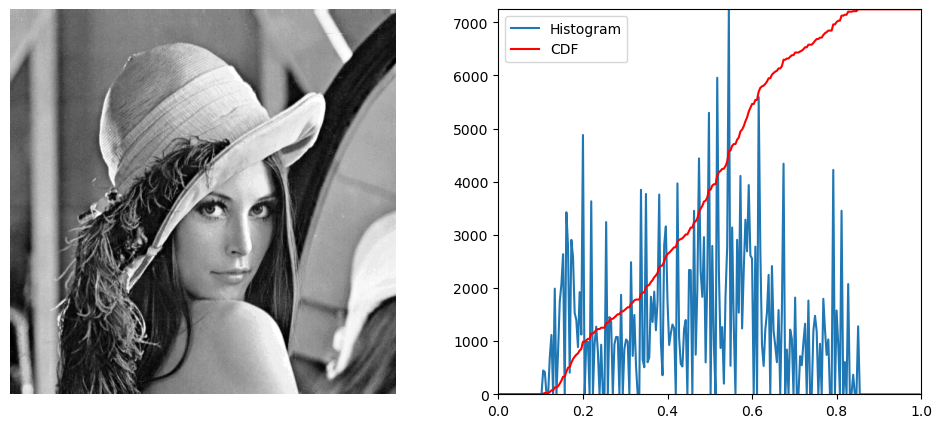

In [2]:
def normalize_image(image):
    return image.astype(np.float32) / 255.0

normalized_image = normalize_image(image)
plot_image_and_histogram(normalized_image, (0, 1))

### Histogram and CDF Before and After Normalization

#### Histogram Definition
For an image $ I $ with pixel values $ x $, the histogram is:
$$
h(x) = \sum_{i,j} \delta(I(i,j) - x)
$$
where $ \delta $ is the Kronecker delta function, counting occurrences of pixel intensity $ x $.

After normalization $ I' = \frac{I}{255} $, the histogram transforms as:
$$
h'(x') = h(255 \cdot x')
$$
This means the histogram shape remains unchanged but is shifted from $ [0, 255] $ to $ [0, 1] $.

#### CDF Definition
The cumulative distribution function (CDF) is:
$$
F(x) = \sum_{k=0}^{x} h(k)
$$
or equivalently:
$$
F(x) = P(X \leq x)
$$
which gives the probability of a pixel having intensity $ \leq x $.

After normalization:
$$
F'(x') = P(X' \leq x') = P(X \leq 255 \cdot x') = F(255 \cdot x')
$$
Thus, the CDF keeps the same shape but is **compressed horizontally** into the range $[0,1]$.

---

## Exercise 2:

Given image $ I $.

Compute $ G_x $ and $ G_y $ using Sobel, Prewitt and Robert filters, visualize results.

Find the Direction and Magnitude of the gradient, visualize results.

Choose a suitable threshold $ \tau $ to modify $ I $ in this manner:

- If $ I(x, y) \geq \tau $ then $ I^{'}(x, y) = 1 $.
- Otherwise $ I^{'}(x, y) = 0 $.

Visualize results.

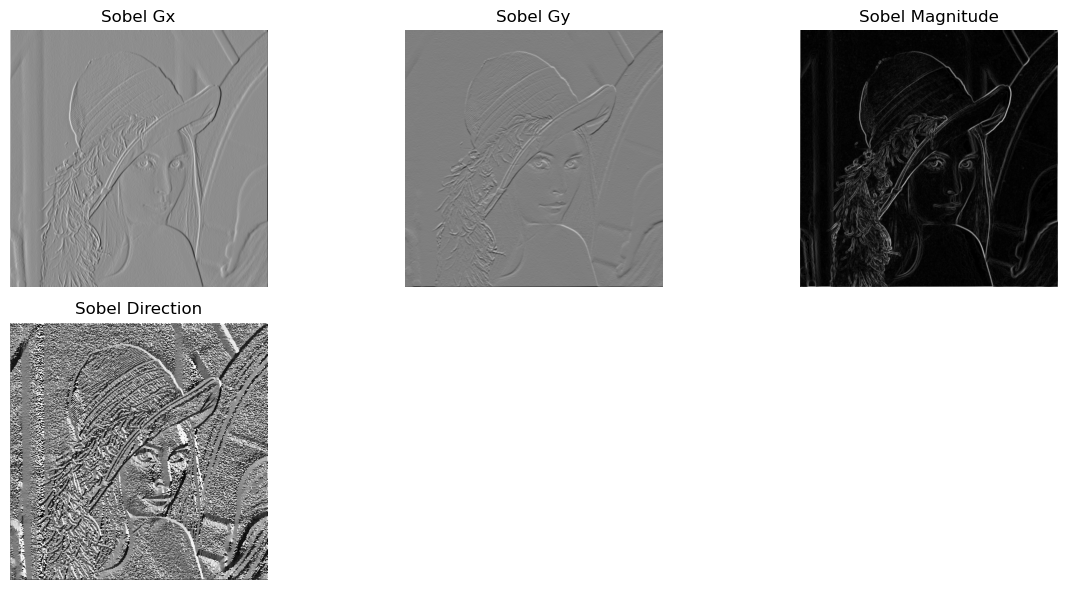

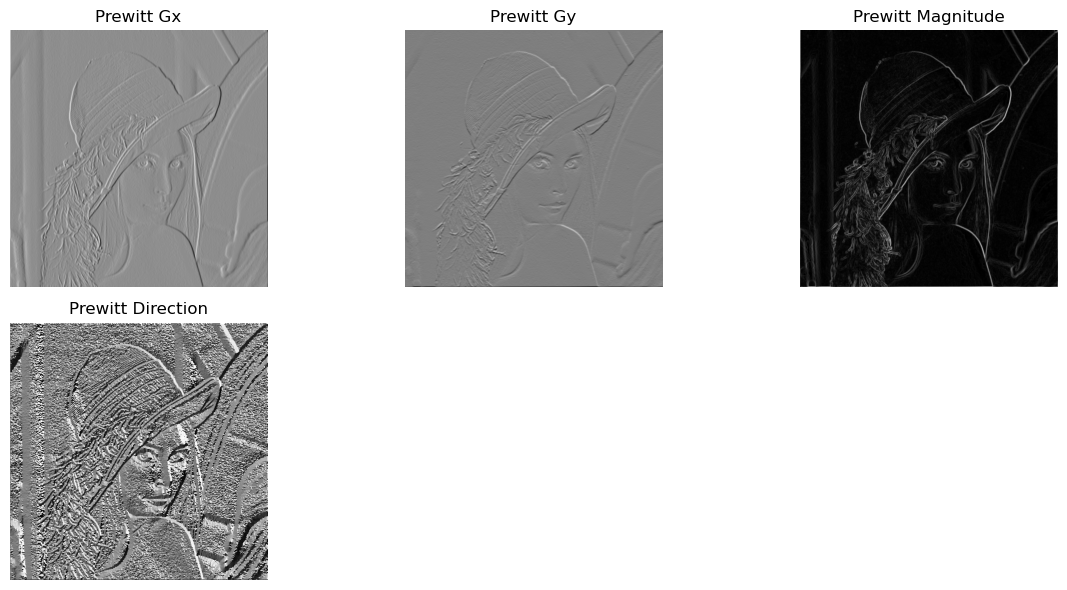

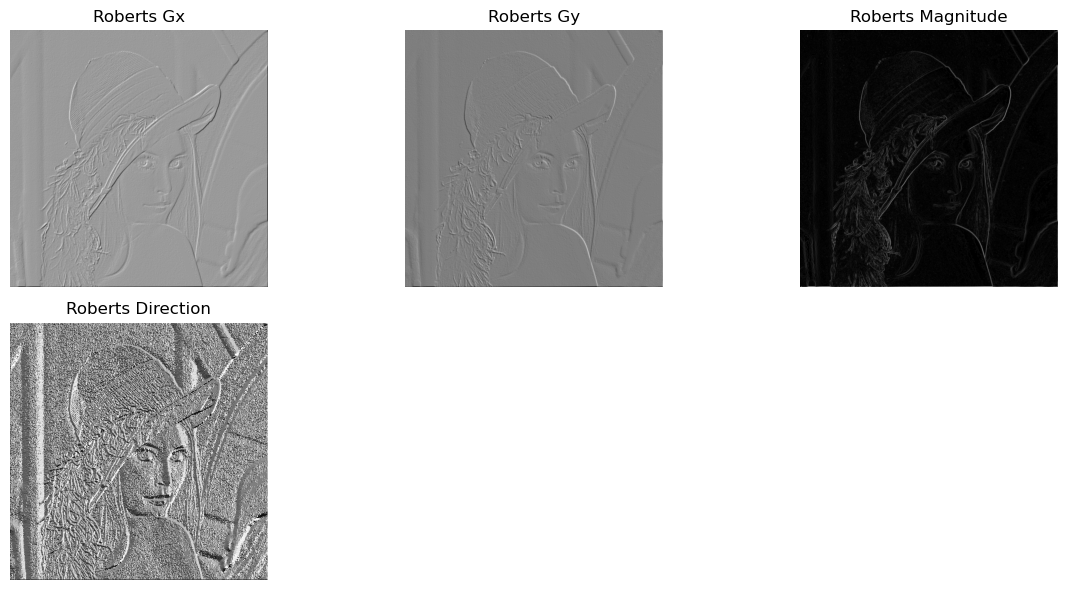

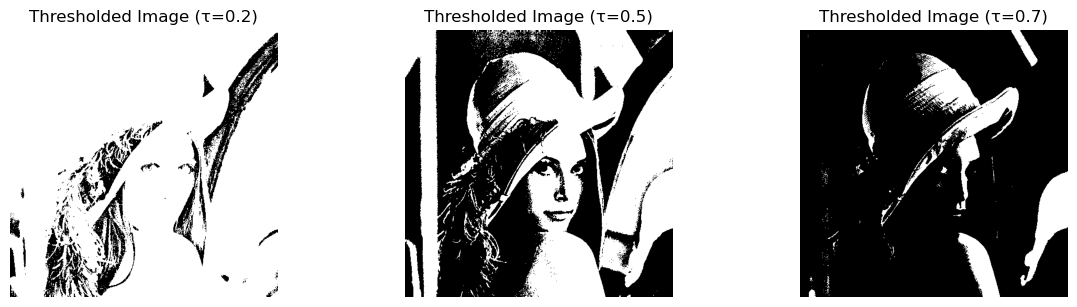

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import sobel, prewitt, convolve

def compute_gradients(image, method='sobel'):
    if method == 'sobel':
        Gx = sobel(image, axis=1, mode='constant')
        Gy = sobel(image, axis=0, mode='constant')
    elif method == 'prewitt':
        Gx = prewitt(image, axis=1, mode='constant')
        Gy = prewitt(image, axis=0, mode='constant')
    elif method == 'roberts':
        roberts_x = np.array([[1, 0], [0, -1]])
        roberts_y = np.array([[0, 1], [-1, 0]])
        Gx = convolve(image, roberts_x, mode='constant')
        Gy = convolve(image, roberts_y, mode='constant')
    else:
        raise ValueError("Unknown method")
    return Gx, Gy

def compute_magnitude_direction(Gx, Gy):
    magnitude = np.sqrt(Gx**2 + Gy**2)
    direction = np.arctan2(Gy, Gx)
    return magnitude, direction

def threshold_image(image, tau=0.5):
    binary_image = np.where(image >= tau, 1, 0)
    return binary_image

def plot_results(images, titles, cmap='gray'):
    plt.figure(figsize=(12, 6))
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(2, 3, i+1)
        plt.imshow(img, cmap=cmap)
        plt.title(title)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

methods = ['sobel', 'prewitt', 'roberts']
gradients = {method: compute_gradients(normalized_image, method) for method in methods}
magnitudes_directions = {method: compute_magnitude_direction(*gradients[method]) for method in methods}

taus = [0.2, 0.5, 0.7]
binary_images = [threshold_image(normalized_image, tau) for tau in taus]

for method in methods:
    Gx, Gy = gradients[method]
    magnitude, direction = magnitudes_directions[method]
    plot_results([Gx, Gy, magnitude, direction], 
                 [f'{method.capitalize()} Gx', f'{method.capitalize()} Gy', 
                  f'{method.capitalize()} Magnitude', f'{method.capitalize()} Direction'])

plot_results(binary_images, [f"Thresholded Image (τ={tau})" for tau in taus], cmap='gray')

### Edge Detection: Sobel, Prewitt, and Roberts Filters

#### Gradient Computation
Given an image $ I $, edge detection involves computing gradients in the **x-direction** $ G_x $ and **y-direction** $ G_y $ using convolution with specific filters.

#### Sobel Operator
The Sobel filters emphasize edges by giving more weight to central pixels:

$$
G_x = I * \begin{bmatrix} -1 & 0 & 1 \\ -2 & 0 & 2 \\ -1 & 0 & 1 \end{bmatrix}, \quad
G_y = I * \begin{bmatrix} -1 & -2 & -1 \\ 0 & 0 & 0 \\ 1 & 2 & 1 \end{bmatrix}
$$

#### Prewitt Operator
Similar to Sobel but without central weighting:

$$
G_x = I * \begin{bmatrix} -1 & 0 & 1 \\ -1 & 0 & 1 \\ -1 & 0 & 1 \end{bmatrix}, \quad
G_y = I * \begin{bmatrix} -1 & -1 & -1 \\ 0 & 0 & 0 \\ 1 & 1 & 1 \end{bmatrix}
$$

#### Roberts Cross Operator
Uses a 2×2 kernel for detecting rapid intensity changes:

$$
G_x = I * \begin{bmatrix} 1 & 0 \\ 0 & -1 \end{bmatrix}, \quad
G_y = I * \begin{bmatrix} 0 & 1 \\ -1 & 0 \end{bmatrix}
$$

#### Gradient Magnitude and Direction
From $ G_x $ and $ G_y $, we compute:

- **Gradient Magnitude** (Edge Strength):
  $$
  G = \sqrt{G_x^2 + G_y^2}
  $$
  Highlights edges by measuring local intensity changes.

- **Gradient Direction** (Edge Orientation):
  $$
  \theta = \tan^{-1} \left( \frac{G_y}{G_x} \right)
  $$
  Defines the angle of the edge in radians.

#### What Are the Outputs?
- **$ G_x $ and $ G_y $**: Two separate images showing intensity changes in horizontal and vertical directions.
- **Gradient Magnitude**: A grayscale image highlighting edge strength.
- **Gradient Direction**: An angle map indicating edge orientations.

Each filter has different sensitivity to noise and edge smoothness:
- **Sobel**: Stronger smoothing, better for noisy images.
- **Prewitt**: Similar to Sobel but less smooth.
- **Roberts**: Detects fine edges but more sensitive to noise.

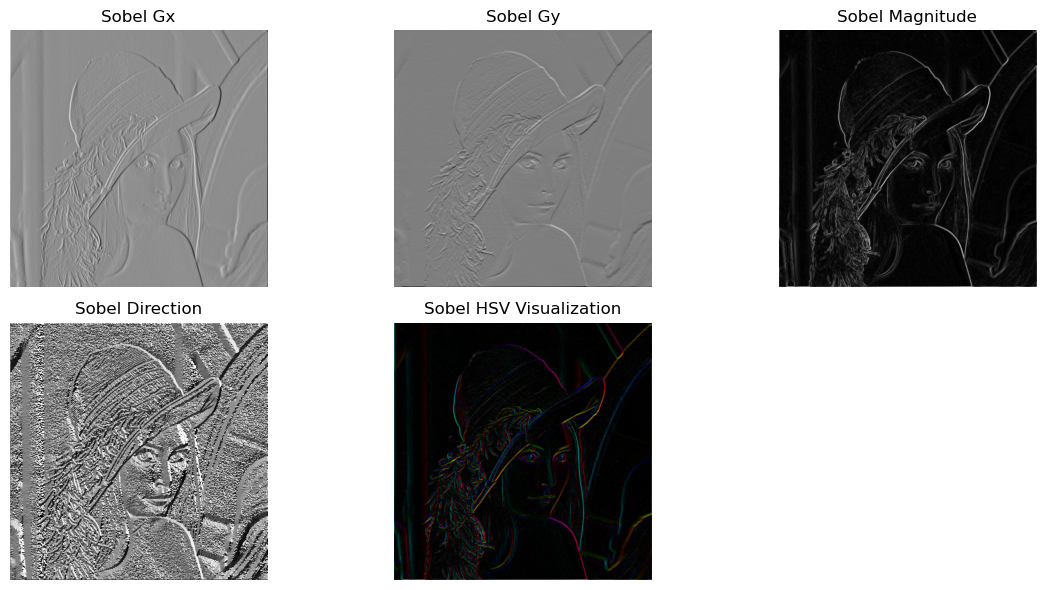

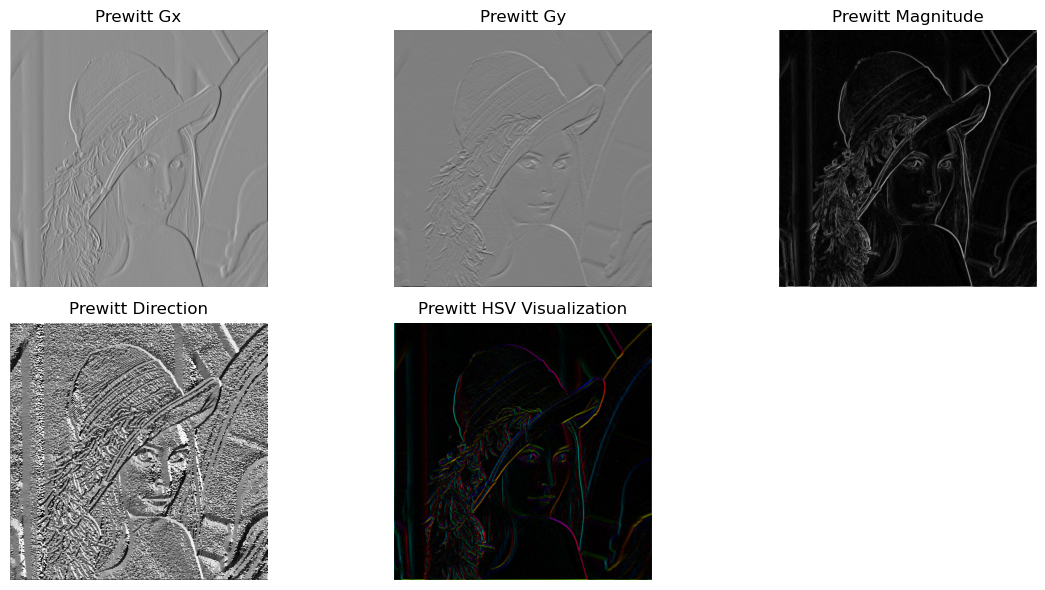

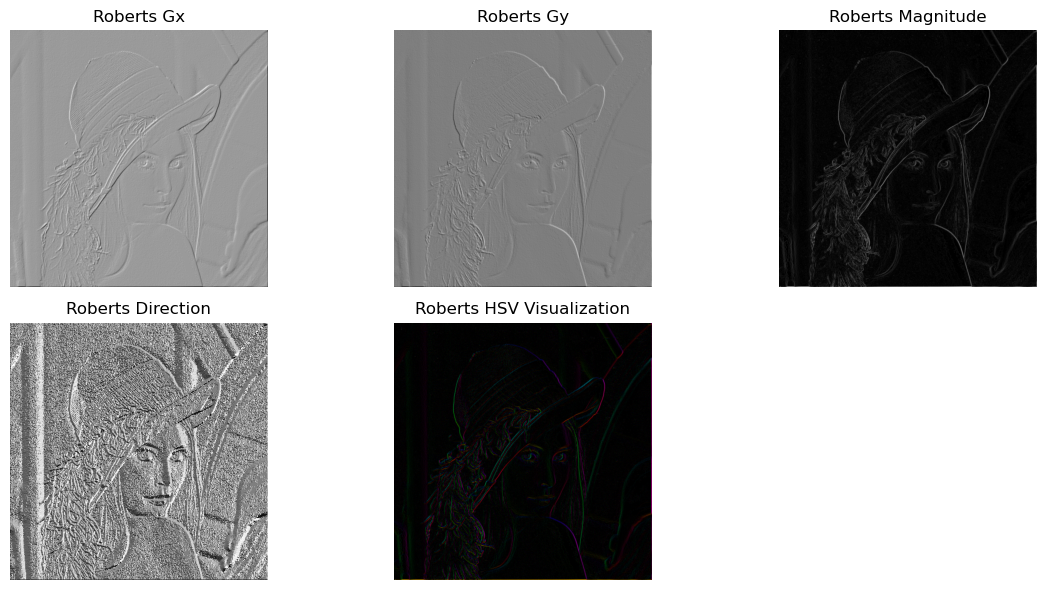

In [7]:
def gradient_to_hsv(magnitude, direction):
    h = (direction + np.pi) / (2 * np.pi) * 180  # Normalize to [0, 180] (Hue)
    s = np.ones_like(h) * 255                    # Full saturation
    v = (magnitude / np.max(magnitude) * 255).astype(np.uint8)  # Normalize magnitude to [0, 255]

    hsv = np.stack([h.astype(np.uint8), s.astype(np.uint8), v], axis=-1)
    rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)  # Convert to RGB for display
    return rgb

methods = ['sobel', 'prewitt', 'roberts']
gradients = {method: compute_gradients(normalized_image, method) for method in methods}
magnitudes_directions = {method: compute_magnitude_direction(*gradients[method]) for method in methods}

for method in methods:
    Gx, Gy = gradients[method]
    magnitude, direction = magnitudes_directions[method]
    hsv_visualization = gradient_to_hsv(magnitude, direction)
    
    plot_results([Gx, Gy, magnitude, direction, hsv_visualization], 
                 [f'{method.capitalize()} Gx', f'{method.capitalize()} Gy', 
                  f'{method.capitalize()} Magnitude', f'{method.capitalize()} Direction',
                  f'{method.capitalize()} HSV Visualization'])

### Why Use HSV for Displaying Gradient Results?

HSV (Hue, Saturation, Value) is a useful color space for visualizing gradient information because:

1. **Hue Represents Direction:**
   - The gradient **direction** ($\theta$) can be mapped to the **hue** (color) component in HSV.
   - This allows different edge orientations to appear in different colors.

2. **Value Represents Magnitude:**
   - The **magnitude** ($G$) can be mapped to the **value** (brightness).
   - Stronger edges appear brighter, weaker edges appear darker.

3. **Saturation Can Be Set to Max:**
   - This ensures that colors remain vivid, making it easy to differentiate directions.

By converting the computed gradient magnitude and direction into HSV and then mapping it to RGB, we can create an intuitive and interpretable visualization.

#### Implementation:
To convert gradients into an HSV-based visualization:
- **Hue ($H$)**: Encodes the gradient direction, scaled to $[0, 180]$.
- **Saturation ($S$)**: Set to maximum ($255$) for strong color contrast.
- **Value ($V$)**: Normalizes the gradient magnitude to $[0, 255]$.

The resulting HSV image is converted to RGB for display, where:
- Different **colors** represent different edge orientations.
- **Brighter** regions indicate stronger edges.

This approach provides a clearer and more interpretable representation of gradient information compared to grayscale.

---

## Exercise 3:

- Perform **Canny Edge Detection** following these steps:
    - Denoise image using Gaussian kernel, size $ 5 \times 5 $.
    - Use `cv2.Canny()` and visualize results.

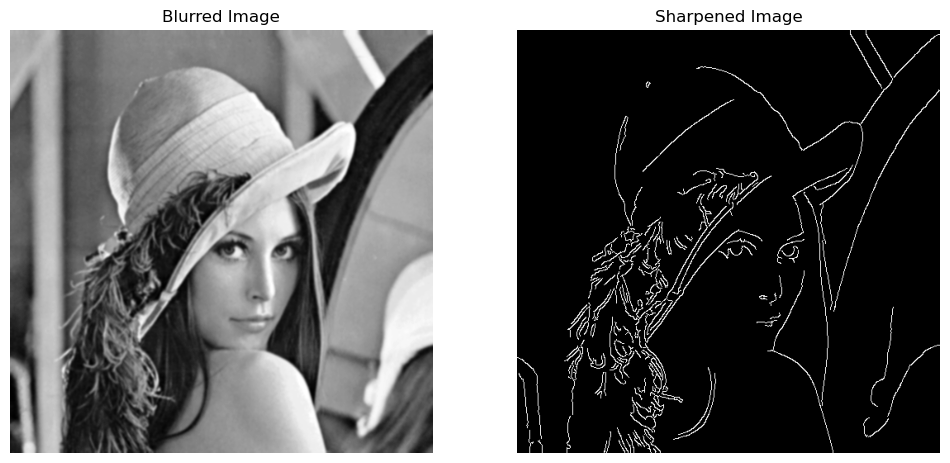

In [4]:
blurred_image = cv2.GaussianBlur((normalized_image * 255).astype(np.uint8), (5, 5), 0)
canny_edges = cv2.Canny(blurred_image, 100, 200)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(blurred_image, cmap='gray')
plt.title("Blurred Image")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(canny_edges, cmap='gray')
plt.title("Sharpened Image")
plt.axis("off")
plt.show()

# **Gaussian Blur and Canny Edge Detection: Mathematical & Algorithmic Explanation**

## **Step 1: Gaussian Blur**
The code first applies a **Gaussian blur** to smooth the image before edge detection:

$$
I' = I * G
$$

where:

- $ I $ is the input image (normalized and converted back to uint8),
- $ G $ is a **Gaussian kernel** defined as:

$$
G(x,y) = \frac{1}{2\pi\sigma^2} e^{-\frac{x^2 + y^2}{2\sigma^2}}
$$

- The kernel size is **$ 5 \times 5 $**, and $ \sigma = 0 $ (automatically determined based on the kernel size).
- This operation is a **convolution** that reduces noise and small variations in the image.

Since OpenCV's `cv2.GaussianBlur` expects an 8-bit integer image, we convert the normalized image back:

$$
I_{\text{blurred}} = \text{cv2.GaussianBlur}((I \times 255), (5,5), 0)
$$

## **Step 2: Canny Edge Detection**
Canny edge detection is a multi-step process:

### **1. Compute Gradients**
The algorithm calculates the **image gradients** using Sobel filters:

$$
G_x = I' * \begin{bmatrix} -1 & 0 & 1 \\ -2 & 0 & 2 \\ -1 & 0 & 1 \end{bmatrix}, \quad
G_y = I' * \begin{bmatrix} -1 & -2 & -1 \\ 0 & 0 & 0 \\ 1 & 2 & 1 \end{bmatrix}
$$

The **gradient magnitude** and **direction** are then computed as:

$$
G = \sqrt{G_x^2 + G_y^2}, \quad \theta = \tan^{-1} \left( \frac{G_y}{G_x} \right)
$$

### **2. Non-Maximum Suppression**
- The algorithm **thins** edges by keeping only local maxima in the gradient direction.
- Pixels that are not part of an edge peak are suppressed.

### **3. Double Thresholding**
- Two thresholds are used: **100 (low)** and **200 (high)**.
- Edge pixels are classified as:
  - **Strong edges** if $ G > 200 $.
  - **Weak edges** if $ 100 \leq G \leq 200 $.
  - **Non-edges** if $ G < 100 $.

### **4. Edge Tracking by Hysteresis**
- Weak edges connected to strong edges are **kept**.
- Isolated weak edges are **discarded**.

The final Canny edge-detected image is:

$$
I_{\text{canny}} = \text{cv2.Canny}(I_{\text{blurred}}, 100, 200)
$$

This results in a **binary edge map**, where:
- **White pixels (255)** represent detected edges.
- **Black pixels (0)** represent non-edge regions.

---

## Exercise 4:

- Perform **Image Sharpnening** following these steps:
    - Convolution with Average kernel, size $ 5 \times 5 $.
    - Apply **Image Sharpening**, visualize results.

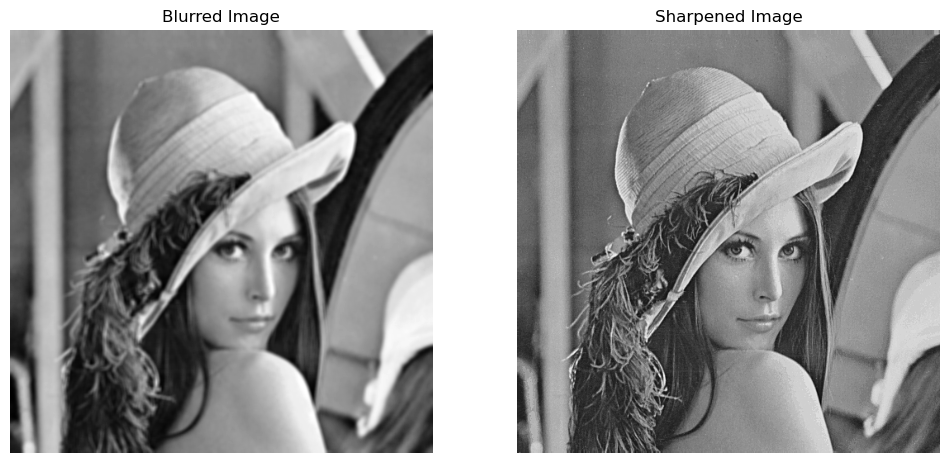

In [5]:
average_kernel = np.ones((5, 5), np.float32) / 25
blurred = cv2.filter2D(normalized_image, -1, average_kernel)
sharpened = cv2.addWeighted(normalized_image, 1.5, blurred, -0.5, 0)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(blurred, cmap='gray')
plt.title("Blurred Image")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(sharpened, cmap='gray')
plt.title("Sharpened Image")
plt.axis("off")
plt.show()

# **Blurring and Sharpening: Mathematical & Algorithmic Explanation**

## **Step 1: Averaging Filter (Blurring)**
The code first applies an **averaging filter** to smooth the image:

$$
K_{\text{avg}} = \frac{1}{25} \begin{bmatrix} 
1 & 1 & 1 & 1 & 1 \\ 
1 & 1 & 1 & 1 & 1 \\ 
1 & 1 & 1 & 1 & 1 \\ 
1 & 1 & 1 & 1 & 1 \\ 
1 & 1 & 1 & 1 & 1 
\end{bmatrix}
$$

This is a **$5 \times 5$ box filter** where each element is $\frac{1}{25}$ to ensure the sum remains 1. The operation applied to the image $ I $ is:

$$
I_{\text{blurred}} = I * K_{\text{avg}}
$$

where $ * $ represents **convolution**.

The implementation in OpenCV is:

$$
I_{\text{blurred}} = \text{cv2.filter2D}(I, -1, K_{\text{avg}})
$$

This results in a smoothed version of the image where each pixel is replaced by the **average** of its neighboring pixels.

## **Step 2: Image Sharpening**
The sharpening operation enhances edges by using a weighted sum of the original and blurred images:

$$
I_{\text{sharpened}} = 1.5 I - 0.5 I_{\text{blurred}}
$$

where:
- The **original image** is weighted by **1.5**, emphasizing its details.
- The **blurred image** is weighted by **-0.5**, which helps remove low-frequency (smooth) components.
- The sum of the weights remains **1** to maintain the image intensity balance.

In OpenCV, this is implemented as:

$$
I_{\text{sharpened}} = \text{cv2.addWeighted}(I, 1.5, I_{\text{blurred}}, -0.5, 0)
$$

where the last parameter (0) is a scalar added to all pixel values (which we set to zero).

## **Effect of These Operations**
- **Blurring (Averaging Filter):** Reduces noise and smooths the image.
- **Sharpening (Unsharp Masking):** Enhances edges by subtracting the blurred version from the original.
- The combination helps improve **details** while controlling **noise**.

This method is commonly used in **image enhancement** tasks.

---